In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
data_path = 'IEMOCAP1.pkl'
checkpoint = 'checkpoint/'
model_name = 'model.ckpt'
pred_name = 'pred0.pkl'
checkpoint_secs = 60

dropout_conv = 1
dropout_linear = 1
dropout_lstm = 1
dropout_fully1 = 1
dropout_fully2 = 1

#decayed_learning rate
decay_rate = 0.99
beta1 = 0.9
beta2 = 0.999

#Moving Average
decay_steps = 570
momentum = 0.99
num_epoch = 30000
relu_clip =  20.0

# Adam optimizer (http://arxiv.org/abs/1412.6980) parameters

adam_beta1 = 0.9
adam_beta2 = 0.999
epsilon =  1e-8
learning_rate =   0.0001

# Batch sizes


train_batch_size = 40
valid_batch_size = 40
test_batch_size =  40
batch_size =  40
save_steps =   10

image_height =   300
image_width = 40
image_channel = 3

linear_num =  786
seq_len =   150
cell_num = 128
hidden1 = 64
hidden2 =  4
attention_size =   1
# attention = False

def attention(inputs, attention_size, time_major=False, return_alphas=False):
    """
    Attention mechanism layer which reduces RNN/Bi-RNN outputs with Attention vector.

    The idea was proposed in the article by Z. Yang et al., "Hierarchical Attention Networks
     for Document Classification", 2016: http://www.aclweb.org/anthology/N16-1174.
    Variables notation is also inherited from the article
    
    Args:
        inputs: The Attention inputs.
            Matches outputs of RNN/Bi-RNN layer (not final state):
                In case of RNN, this must be RNN outputs `Tensor`:
                    If time_major == False (default), this must be a tensor of shape:
                        `[batch_size, max_time, cell.output_size]`.
                    If time_major == True, this must be a tensor of shape:
                        `[max_time, batch_size, cell.output_size]`.
                In case of Bidirectional RNN, this must be a tuple (outputs_fw, outputs_bw) containing the forward and
                the backward RNN outputs `Tensor`.
                    If time_major == False (default),
                        outputs_fw is a `Tensor` shaped:
                        `[batch_size, max_time, cell_fw.output_size]`
                        and outputs_bw is a `Tensor` shaped:
                        `[batch_size, max_time, cell_bw.output_size]`.
                    If time_major == True,
                        outputs_fw is a `Tensor` shaped:
                        `[max_time, batch_size, cell_fw.output_size]`
                        and outputs_bw is a `Tensor` shaped:
                        `[max_time, batch_size, cell_bw.output_size]`.
        attention_size: Linear size of the Attention weights.
        time_major: The shape format of the `inputs` Tensors.
            If true, these `Tensors` must be shaped `[max_time, batch_size, depth]`.
            If false, these `Tensors` must be shaped `[batch_size, max_time, depth]`.
            Using `time_major = True` is a bit more efficient because it avoids
            transposes at the beginning and end of the RNN calculation.  However,
            most TensorFlow data is batch-major, so by default this function
            accepts input and emits output in batch-major form.
        return_alphas: Whether to return attention coefficients variable along with layer's output.
            Used for visualization purpose.
    Returns:
        The Attention output `Tensor`.
        In case of RNN, this will be a `Tensor` shaped:
            `[batch_size, cell.output_size]`.
        In case of Bidirectional RNN, this will be a `Tensor` shaped:
            `[batch_size, cell_fw.output_size + cell_bw.output_size]`.
    """

    if isinstance(inputs, tuple):
        # In case of Bi-RNN, concatenate the forward and the backward RNN outputs.
        inputs = tf.concat(inputs, 2)

    if time_major:
        # (T,B,D) => (B,T,D)
        inputs = tf.array_ops.transpose(inputs, [1, 0, 2])

    hidden_size = inputs.shape[2].value  # D value - hidden size of the RNN layer

    # Trainable parameters
    W_omega = tf.Variable(tf.random_normal([hidden_size, attention_size], stddev=0.1))
    b_omega = tf.Variable(tf.random_normal([attention_size], stddev=0.1))
    u_omega = tf.Variable(tf.random_normal([attention_size], stddev=0.1))

    # Applying fully connected layer with non-linear activation to each of the B*T timestamps;
    #  the shape of `v` is (B,T,D)*(D,A)=(B,T,A), where A=attention_size
    #v = tf.tanh(tf.tensordot(inputs, W_omega, axes=1) + b_omega)
    v = tf.sigmoid(tf.tensordot(inputs, W_omega, axes=1) + b_omega)
    # For each of the timestamps its vector of size A from `v` is reduced with `u` vector
    vu = tf.tensordot(v, u_omega, axes=1)   # (B,T) shape
    alphas = tf.nn.softmax(vu)              # (B,T) shape also

    # Output of (Bi-)RNN is reduced with attention vector; the result has (B,D) shape
    output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), 1)

    if not return_alphas:
        return output
    else:
        return output, alphas


In [3]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.disable_v2_behavior()

epsilon = 1e-3

def leaky_relu(x, leakiness=0.0):
    return tf.where(tf.less(x, 0.0), leakiness * x, x, name='leaky_relu')

def batch_norm_wrapper(inputs, is_training, decay = 0.999):

    scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
    beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)

    if is_training is not None:
        batch_mean, batch_var = tf.nn.moments(inputs,[0])
        train_mean = tf.assign(pop_mean,
                               pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var,
                              pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs,
                batch_mean, batch_var, beta, scale, epsilon)
    else:
        return tf.nn.batch_normalization(inputs,
            pop_mean, pop_var, beta, scale, epsilon)

def acrnn(inputs, num_classes=4,
                  is_training=True,
                  L1=128,
                  L2=256,
                  cell_units=128,
                  num_linear=768,
                  p=10,
                  time_step=150,
                  F1=64,
                  dropout_keep_prob=1):
    
    global ndims
    layer1_filter = tf.get_variable('layer1_filter', shape=[5, 3, 3, L1], dtype=tf.float32, 
                                    initializer=tf.truncated_normal_initializer(stddev=0.1))
    layer1_bias = tf.get_variable('layer1_bias', shape=[L1], dtype=tf.float32,
                                  initializer=tf.constant_initializer(0.1))
    layer1_stride = [1, 1, 1, 1]
    layer2_filter = tf.get_variable('layer2_filter', shape=[5, 3, L1, L2], dtype=tf.float32, 
                                    initializer=tf.truncated_normal_initializer(stddev=0.1))
    layer2_bias = tf.get_variable('layer2_bias', shape=[L2], dtype=tf.float32,
                                  initializer=tf.constant_initializer(0.1))
    layer2_stride = [1, 1, 1, 1]
    layer3_filter = tf.get_variable('layer3_filter', shape=[5, 3, L2, L2], dtype=tf.float32, 
                                    initializer=tf.truncated_normal_initializer(stddev=0.1))
    layer3_bias = tf.get_variable('layer3_bias', shape=[L2], dtype=tf.float32,
                                  initializer=tf.constant_initializer(0.1))
    layer3_stride = [1, 1, 1, 1]
    layer4_filter = tf.get_variable('layer4_filter', shape=[5, 3, L2, L2], dtype=tf.float32, 
                                    initializer=tf.truncated_normal_initializer(stddev=0.1))
    layer4_bias = tf.get_variable('layer4_bias', shape=[L2], dtype=tf.float32,
                                  initializer=tf.constant_initializer(0.1))
    layer4_stride = [1, 1, 1, 1]
    layer5_filter = tf.get_variable('layer5_filter', shape=[5, 3, L2, L2], dtype=tf.float32, 
                                    initializer=tf.truncated_normal_initializer(stddev=0.1))
    layer5_bias = tf.get_variable('layer5_bias', shape=[L2], dtype=tf.float32,
                                  initializer=tf.constant_initializer(0.1))
    layer5_stride = [1, 1, 1, 1]
    layer6_filter = tf.get_variable('layer6_filter', shape=[5, 3, L2, L2], dtype=tf.float32, 
                                    initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.1))
    layer6_bias = tf.get_variable('layer6_bias', shape=[L2], dtype=tf.float32,
                                  initializer=tf.constant_initializer(0.1))
    layer6_stride = [1, 1, 1, 1]
    
    linear1_weight = tf.get_variable('linear1_weight', shape=[p*L2,num_linear], dtype=tf.float32,
                                    initializer=tf.truncated_normal_initializer(stddev=0.1))
    linear1_bias = tf.get_variable('linear1_bias', shape=[num_linear], dtype=tf.float32,
                                  initializer=tf.compat.v1.constant_initializer(0.1))
 
    fully1_weight = tf.get_variable('fully1_weight', shape=[2*cell_units,F1], dtype=tf.float32,
                                    initializer=tf.truncated_normal_initializer(stddev=0.1))
    fully1_bias = tf.get_variable('fully1_bias', shape=[F1], dtype=tf.float32,
                                  initializer=tf.constant_initializer(0.1))
    fully2_weight = tf.get_variable('fully2_weight', shape=[F1,num_classes], dtype=tf.float32,
                                    initializer=tf.truncated_normal_initializer(stddev=0.1))
    fully2_bias = tf.get_variable('fully2_bias', shape=[num_classes], dtype=tf.float32,
                                  initializer=tf.constant_initializer(0.1))
    
    layer1 = tf.nn.conv2d(inputs, layer1_filter, layer1_stride, padding='SAME')
    layer1 = tf.nn.bias_add(layer1,layer1_bias)
    layer1 = leaky_relu(layer1, 0.01)
    layer1 = tf.nn.max_pool(layer1,ksize=[1, 2, 4, 1], strides=[1, 2, 4, 1], padding='VALID', name='max_pool')
    layer1 = tf.layers.dropout(layer1, rate = 1 - keep_prob)
    
    layer2 = tf.nn.conv2d(layer1, layer2_filter, layer2_stride, padding='SAME')
    layer2 = tf.nn.bias_add(layer2,layer2_bias)
    layer2 = leaky_relu(layer2, 0.01)
    layer2 = tf.layers.dropout(layer2, rate = 1 - keep_prob)
    
    layer3 = tf.nn.conv2d(layer2, layer3_filter, layer3_stride, padding='SAME')
    layer3 = tf.nn.bias_add(layer3,layer3_bias)
    layer3 = leaky_relu(layer3, 0.01)
    layer3 = tf.layers.dropout(layer3, rate = 1 - keep_prob)
    
    layer4 = tf.nn.conv2d(layer3, layer4_filter, layer4_stride, padding='SAME')
    layer4 = tf.nn.bias_add(layer4,layer4_bias)
    layer4 = leaky_relu(layer4, 0.01)
    layer4 = tf.layers.dropout(layer4, rate = 1 - keep_prob)
    
    layer5 = tf.nn.conv2d(layer4, layer5_filter, layer5_stride, padding='SAME')
    layer5 = tf.nn.bias_add(layer5,layer5_bias)
    layer5 = leaky_relu(layer5, 0.01)    
    layer5 = tf.layers.dropout(layer5, rate = 1 - keep_prob)

    layer6 = tf.nn.conv2d(layer5, layer6_filter, layer6_stride, padding='SAME')
    layer6 = tf.nn.bias_add(layer6,layer6_bias)
    layer6 = leaky_relu(layer6, 0.01)    
    layer6 = tf.layers.dropout(layer6, rate = 1 - keep_prob)
    
    layer6 = tf.reshape(layer6,[-1,time_step,L2*p])
    layer6 = tf.reshape(layer6, [-1,p*L2])
    
    linear1 = tf.matmul(layer6,linear1_weight) + linear1_bias
    linear1 = batch_norm_wrapper(linear1,is_training)
    linear1 = leaky_relu(linear1, 0.01)
    #linear1 = batch_norm_wrapper(linear1,is_training)
    linear1 = tf.reshape(linear1, [-1, time_step, num_linear])
    
    
    
    # Define lstm cells with tensorflow
    # Forward direction cell
    gru_fw_cell1 = tf.nn.rnn_cell.BasicLSTMCell(cell_units, forget_bias=1.0)
    # Backward direction cell
    gru_bw_cell1 = tf.nn.rnn_cell.BasicLSTMCell(cell_units, forget_bias=1.0)
    
    # Now we feed `layer_3` into the LSTM BRNN cell and obtain the LSTM BRNN output.
    outputs1, output_states1 = tf.nn.bidirectional_dynamic_rnn(cell_fw=gru_fw_cell1,
                                                             cell_bw=gru_bw_cell1,
                                                             inputs= linear1,
                                                             dtype=tf.float32,
                                                             time_major=False,
                                                             scope='LSTM1')

    # Attention layer
    gru, alphas = attention(outputs1, 1, return_alphas=True)
    
    
    fully1 = tf.matmul(gru,fully1_weight) + fully1_bias
    fully1 = leaky_relu(fully1, 0.01)
    fully1 = tf.nn.dropout(fully1, dropout_keep_prob)
    
    
    Ylogits = tf.matmul(fully1, fully2_weight) + fully2_bias
    #Ylogits = tf.nn.softmax(Ylogits)
    return Ylogits


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
def load_data(in_dir):
    f = open(in_dir,'rb')
    train_data,train_label,test_data,test_label,valid_data,valid_label,Valid_label,Test_label,pernums_test,pernums_valid = pickle.load(f)
    return train_data,train_label,test_data,test_label,valid_data,valid_label,Valid_label,Test_label,pernums_test,pernums_valid

def dense_to_one_hot(labels_dense, num_classes):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [5]:
import numpy as np
import pickle
from sklearn.metrics import recall_score as recall
from sklearn.metrics import confusion_matrix as confusion
import os

num_classes = 4
is_adam = True
dropout_keep_prob = 1
data_path = 'IEMOCAP.pkl'
checkpoint = 'checkpoint/'

train_data,train_label,test_data,test_label,valid_data,valid_label,Valid_label,Test_label,pernums_test,pernums_valid = load_data(data_path)



train_label = dense_to_one_hot(train_label,num_classes)
valid_label = dense_to_one_hot(valid_label,num_classes)
Valid_label = dense_to_one_hot(Valid_label,num_classes)

valid_size = valid_data.shape[0]
dataset_size = train_data.shape[0]
vnum = pernums_valid.shape[0]
best_valid_uw = 0



X = tf.compat.v1.placeholder(tf.float32, shape=[None, image_height,image_width,image_channel])
Y = tf.compat.v1.placeholder(tf.int32, shape=[None, num_classes])

is_training = tf.compat.v1.placeholder(tf.bool)
lr = tf.compat.v1.placeholder(tf.float32)
keep_prob = tf.compat.v1.placeholder(tf.float32)

Ylogits = acrnn(X, is_training=is_training, dropout_keep_prob=keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels =  Y, logits =  Ylogits)
cost = tf.reduce_mean(cross_entropy)
var_trainable_op = tf.trainable_variables()
if is_adam:
    # not apply gradient clipping
    train_op = tf.train.AdamOptimizer(lr).minimize(cost)            
else:
    # apply gradient clipping
    grads, _ = tf.clip_by_global_norm(tf.gradients(cost, var_trainable_op), 5)
    opti = tf.train.AdamOptimizer(lr)
    train_op = opti.apply_gradients(zip(grads, var_trainable_op))
    
correct_pred = tf.equal(tf.argmax(Ylogits, 1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
saver=tf.train.Saver(tf.global_variables())
init = tf.global_variables_initializer()

epocs = []
validation_accuracy = []
training_accuracy = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_epoch):
        #learning_rate = FLAGS.learning_rate            
        start = (i * batch_size) % dataset_size
        end = min(start+batch_size, dataset_size)
        [_,tcost,tracc] = sess.run([train_op,cost,accuracy], feed_dict={X:train_data[start:end,:,:,:], Y:train_label[start:end,:],
                                        is_training:True, keep_prob:dropout_keep_prob, lr:learning_rate})
        if i % 5 == 0:
            #for valid data
            valid_iter = divmod((valid_size),batch_size)[0]
            y_pred_valid = np.empty((valid_size,num_classes),dtype=np.float32)
            y_valid = np.empty((vnum,4),dtype=np.float32)
            index = 0
            cost_valid = 0
            if(valid_size < batch_size):
                loss, y_pred_valid = sess.run([cross_entropy,Ylogits],feed_dict = {X:valid_data, Y:Valid_label,is_training:False, keep_prob:1})
                cost_valid = cost_valid + np.sum(loss)
            for v in range(valid_iter):
                v_begin = v*batch_size
                v_end = (v+1)*batch_size
                if(v == valid_iter-1):
                    if(v_end < valid_size):
                        v_end = valid_size
                loss, y_pred_valid[v_begin:v_end,:] = sess.run([cross_entropy,Ylogits],feed_dict = {X:valid_data[v_begin:v_end],Y:Valid_label[v_begin:v_end],is_training:False, keep_prob:1})
                cost_valid = cost_valid + np.sum(loss)
            cost_valid = cost_valid/valid_size
            
            for s in range(vnum):
                y_valid[s,:] = np.max(y_pred_valid[index:index+pernums_valid[s],:],0)
                index = index + pernums_valid[s]

            valid_acc_uw = recall(np.argmax(valid_label,1),np.argmax(y_valid,1),average='macro')
            valid_conf = confusion(np.argmax(valid_label, 1),np.argmax(y_valid,1))
            
            if valid_acc_uw > best_valid_uw:
                best_valid_uw = valid_acc_uw
                best_valid_conf = valid_conf
                saver.save(sess, os.path.join(checkpoint, model_name), global_step = i+1)
            
            print ("*****************************************************************")
            print ("Epoch: %05d" %(i+1))
            epocs.append(i+1)
            print ("Training cost: %2.3g" %tcost)   
            print ("Training accuracy: %3.4g" %tracc) 
            training_accuracy.append(tracc)
            print ("Valid cost: %2.3g" %cost_valid)
            print ("Valid_UA: %3.4g" %valid_acc_uw) 
            validation_accuracy.append(valid_acc_uw)
            print ("Best valid_UA: %3.4g" %best_valid_uw) 
            print ('Valid Confusion Matrix:["ang","sad","hap","neu"]')
            print (valid_conf)
            print ('Best Valid Confusion Matrix:["ang","sad","hap","neu"]')
            print (best_valid_conf)
            print ("*****************************************************************" )

Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\SHUBHAM\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:268: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  warnings.warn('`tf.layers.dropout` is deprecated and '
C:\Users\SHUBHAM\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
C:\Users\SHUBHAM\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:708: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
C:\Users\S

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

*****************************************************************
Epoch: 00001
Training cost: 1.4
Training accuracy: 0.225
Valid cost: 1.35
Valid_UA: 0.5076
Best valid_UA: 0.5076
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[16  1  1  0]
 [ 2 69  2  0]
 [14 31 11  0]
 [30 95 26  0]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[16  1  1  0]
 [ 2 69  2  0]
 [14 31 11  0]
 [30 95 26  0]]
*****************************************************************
*****************************************************************
Epoch: 00006
Training cost: 1.16
Training accuracy: 0.45
Valid cost: 1.26
Valid_UA: 0.5663
Best valid_UA: 0.5663
Valid Confusion Matrix:["ang","sad","hap","ne

*****************************************************************
Epoch: 00081
Training cost: 0.568
Training accuracy: 0.8
Valid cost: 1.1
Valid_UA: 0.5562
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[15  0  2  1]
 [ 2 43  7 21]
 [ 5  5 16 30]
 [19 19 35 78]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
*****************************************************************
Epoch: 00086
Training cost: 0.786
Training accuracy: 0.7
Valid cost: 1.12
Valid_UA: 0.5783
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[16  0  1  1]
 [ 0 53  8 12]
 [ 8  8 15 25]
 [22 28 36 65]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
*************************************************************

*****************************************************************
Epoch: 00171
Training cost: 0.431
Training accuracy: 0.85
Valid cost: 1.12
Valid_UA: 0.5633
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[15  0  2  1]
 [ 1 39 18 15]
 [ 5  6 24 21]
 [16 14 52 69]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
*****************************************************************
Epoch: 00176
Training cost: 0.651
Training accuracy: 0.8
Valid cost: 1.12
Valid_UA: 0.5958
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 44 12 16]
 [ 9  6 17 24]
 [24 25 30 72]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
***********************************************************

*****************************************************************
Epoch: 00261
Training cost: 0.296
Training accuracy: 0.95
Valid cost: 1.16
Valid_UA: 0.6028
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[17  0  0  1]
 [ 0 42 13 18]
 [ 9  6 21 20]
 [19 14 40 78]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
*****************************************************************
Epoch: 00266
Training cost: 0.466
Training accuracy: 0.825
Valid cost: 1.06
Valid_UA: 0.5894
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[17  0  1  0]
 [ 0 49 10 14]
 [ 7  6 13 30]
 [16 26 32 77]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
*********************************************************

*****************************************************************
Epoch: 00351
Training cost: 0.121
Training accuracy:   1
Valid cost: 1.27
Valid_UA: 0.5101
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[15  0  2  1]
 [ 0 29  8 36]
 [ 6  2  9 39]
 [16  7 30 98]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
*****************************************************************
Epoch: 00356
Training cost: 0.361
Training accuracy: 0.9
Valid cost: 1.37
Valid_UA: 0.5357
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[16  0  1  1]
 [ 0 45 14 14]
 [14  7  9 26]
 [28 18 33 72]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
************************************************************

*****************************************************************
Epoch: 00441
Training cost: 0.059
Training accuracy:   1
Valid cost: 1.53
Valid_UA: 0.5497
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[17  0  1  0]
 [ 0 33 20 20]
 [10  4 16 26]
 [21  9 43 78]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
*****************************************************************
Epoch: 00446
Training cost: 0.146
Training accuracy: 0.95
Valid cost: 1.42
Valid_UA: 0.5559
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[15  0  2  1]
 [ 0 45 19  9]
 [ 9  8 17 22]
 [12 19 49 71]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
***********************************************************

*****************************************************************
Epoch: 00531
Training cost: 0.0463
Training accuracy:   1
Valid cost: 1.81
Valid_UA: 0.5178
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[17  0  1  0]
 [ 0 28 28 17]
 [13  3 19 21]
 [27  9 54 61]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
*****************************************************************
Epoch: 00536
Training cost: 0.0738
Training accuracy:   1
Valid cost: 1.57
Valid_UA: 0.5379
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[15  0  2  1]
 [ 0 43 15 15]
 [ 8  7 16 25]
 [11 23 50 67]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
**********************************************************

*****************************************************************
Epoch: 00621
Training cost: 0.0953
Training accuracy: 0.95
Valid cost: 1.98
Valid_UA: 0.5262
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[17  0  1  0]
 [ 1 29 28 15]
 [11  2 19 24]
 [20  9 58 64]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
*****************************************************************
Epoch: 00626
Training cost: 0.0825
Training accuracy: 0.975
Valid cost: 1.64
Valid_UA: 0.5456
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[17  0  1  0]
 [ 0 43 13 17]
 [ 6 11 10 29]
 [13 25 42 71]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
*******************************************************

*****************************************************************
Epoch: 00711
Training cost: 0.0157
Training accuracy:   1
Valid cost: 2.57
Valid_UA: 0.4873
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[17  0  1  0]
 [ 3 36 28  6]
 [16  5 19 16]
 [36 18 71 26]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
*****************************************************************
Epoch: 00716
Training cost: 0.0973
Training accuracy: 0.95
Valid cost: 2.05
Valid_UA: 0.5519
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[17  0  1  0]
 [ 0 45 14 14]
 [13  6 11 26]
 [31 22 30 68]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
*********************************************************

*****************************************************************
Epoch: 00801
Training cost: 0.0415
Training accuracy: 0.975
Valid cost: 2.11
Valid_UA: 0.509
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[16  0  2  0]
 [ 1 42 18 12]
 [17  5 12 22]
 [35 18 44 54]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
*****************************************************************
Epoch: 00806
Training cost: 0.045
Training accuracy:   1
Valid cost: 1.74
Valid_UA: 0.5665
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[17  0  0  1]
 [ 0 47 18  8]
 [10  7 12 27]
 [25 24 32 70]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
**********************************************************

*****************************************************************
Epoch: 00891
Training cost: 0.0237
Training accuracy:   1
Valid cost: 2.71
Valid_UA: 0.4866
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[17  0  1  0]
 [ 6 47 15  5]
 [26 11 13  6]
 [68 21 43 19]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
*****************************************************************
Epoch: 00896
Training cost: 0.208
Training accuracy: 0.95
Valid cost: 1.8
Valid_UA: 0.5478
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[15  0  2  1]
 [ 1 52 14  6]
 [ 6 11 15 24]
 [20 35 39 57]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
***********************************************************

*****************************************************************
Epoch: 00981
Training cost: 0.00562
Training accuracy:   1
Valid cost: 2.14
Valid_UA: 0.5234
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[16  0  2  0]
 [ 0 46 15 12]
 [15  9 14 18]
 [28 22 52 49]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
*****************************************************************
Epoch: 00986
Training cost: 0.012
Training accuracy:   1
Valid cost: 2.19
Valid_UA: 0.5183
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[16  0  2  0]
 [ 0 45 15 13]
 [16  9 14 17]
 [28 23 52 48]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
**********************************************************

*****************************************************************
Epoch: 01071
Training cost: 0.00198
Training accuracy:   1
Valid cost: 2.38
Valid_UA: 0.5341
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[17  0  1  0]
 [ 0 47 15 11]
 [14  8 14 20]
 [26 26 54 45]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
*****************************************************************
Epoch: 01076
Training cost: 0.0047
Training accuracy:   1
Valid cost: 2.38
Valid_UA: 0.5341
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[17  0  1  0]
 [ 0 47 15 11]
 [14  8 14 20]
 [26 26 54 45]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
*********************************************************

*****************************************************************
Epoch: 01161
Training cost: 0.00149
Training accuracy:   1
Valid cost: 2.46
Valid_UA: 0.5396
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[17  0  1  0]
 [ 0 46 17 10]
 [13  7 16 20]
 [27 25 54 45]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************
*****************************************************************
Epoch: 01166
Training cost: 0.00337
Training accuracy:   1
Valid cost: 2.46
Valid_UA: 0.5396
Best valid_UA: 0.6157
Valid Confusion Matrix:["ang","sad","hap","neu"]
[[17  0  1  0]
 [ 0 46 17 10]
 [13  7 16 20]
 [27 25 54 45]]
Best Valid Confusion Matrix:["ang","sad","hap","neu"]
[[18  0  0  0]
 [ 1 55  6 11]
 [11  9 16 20]
 [28 30 29 64]]
*****************************************************************


KeyboardInterrupt: 

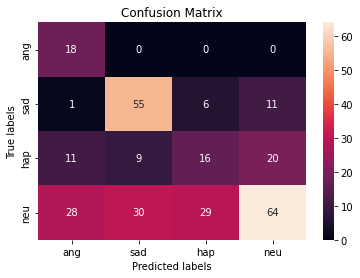

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(best_valid_conf, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(["ang","sad","hap","neu"]); ax.yaxis.set_ticklabels(["ang","sad","hap","neu"]);

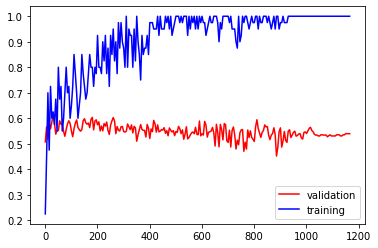

In [11]:
import matplotlib.pyplot as plt
import numpy as np
  
# define data values
x = epocs  # X-axis points
y = validation_accuracy  # Y-axis points
z =   training_accuracy
plt.plot(x, y, 'red')
plt.plot(x, z, 'blue') # Plot the chart
plt.legend(["validation", "training"], loc ="lower right")
plt.show()  # display

In [ ]:
# define data values
x = epocs  # X-axis points
y = validation_accuracy  # Y-axis points
  
plt.plot(x, y)  # Plot the chart
plt.show()  # display